In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)
import numpy as np
import pandas as pd
from utils.utils import PROJECT_DATA_DIR
import os
import mxnet as mx
import mxnet.ndarray as nd
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from load_preprocess import (load_data,
                             get_xy,
                             scale_data,
                             binarize_y,
                             prepare_data)
import warnings
warnings.filterwarnings("ignore",  category=DeprecationWarning)
from DL_mxnet_symbol import train_dnn, train_lstm

C:\Users\gilbe\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = load_data(file='all_training_400_minisensor_1.csv')
test = load_data(file='all_test_400_minisensor.csv')
xtrain, ytrain = get_xy(train)
xtest, ytest = get_xy(test)
ytrain = binarize_y(ytrain, arg_list=[1])
print(ytrain.unique())
ytest = binarize_y(ytest, arg_list=[1])

xtrain_sc, xtest_sc = scale_data(xtrain, xtest)

[0 1]


In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,-3,3,4,-3,3,4,1,-3,2,0,...,0,0,0,3,0,-4,-2,0,-5,8
1,3,0,0,1,0,0,0,2,0,0,...,-1,0,-7,3,-1,-7,7,-1,-5,7
2,1,-3,7,0,1,4,-3,4,0,-2,...,-4,1,8,-2,1,12,0,4,11,4
3,4,1,-1,3,4,-8,3,4,-1,3,...,0,4,-5,-1,3,6,3,4,7,6
4,0,-4,0,5,0,0,5,0,-5,0,...,0,-4,-4,3,3,0,4,3,1,8


In [4]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,1,-1,-1,0,2,-1,-2,2,1,-2,...,-2,-3,0,0,0,1,0,2,0,8
1,3,6,-13,3,6,-8,3,6,-2,-1,...,-1,7,44,14,7,51,23,11,59,6
2,-1,2,-1,2,0,-1,-4,-3,0,-4,...,-1,0,-1,-1,0,-8,-3,0,-3,5
3,48,18,-57,48,-3,-148,37,-33,-241,29,...,4,0,-17,9,0,-17,6,0,-21,8
4,-2,-2,0,0,-3,1,-3,0,0,3,...,0,0,4,0,-3,6,3,-3,4,8


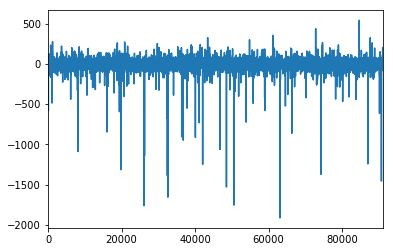

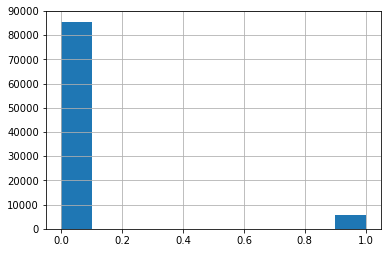

In [5]:
xtrain[xtrain.columns[0]].plot()
plt.show()
ytrain.hist()
plt.show()

In [6]:
ytrain.unique()

array([0, 1], dtype=int64)

In [7]:
(ytrain.shape, ytest.shape)

((91104,), (22776,))

In [8]:
xtrain_mx = mx.nd.array(xtrain_sc, dtype=np.float32)
ytrain_mx = mx.nd.array(ytrain.reshape(-1, 1))
xtest_mx = mx.nd.array(xtest_sc, dtype=np.float32)
ytest_mx = mx.nd.array(ytest.reshape(-1, 1))
batch_size=2**9

train_iter = mx.io.NDArrayIter(
    xtrain_mx,
    ytrain_mx,
    batch_size=batch_size,
    shuffle=True)

val_iter = mx.io.NDArrayIter(
    xtest_mx,
    ytest_mx,
    batch_size=batch_size)


In [9]:
train_dnn(train_iter, val_iter)

INFO:root:Epoch[0] Batch [100]	Speed: 123703.55 samples/sec	accuracy=0.941097
INFO:root:Epoch[0] Train-accuracy=0.937373
INFO:root:Epoch[0] Time cost=0.821
INFO:root:Epoch[0] Validation-accuracy=0.938802
INFO:root:Epoch[1] Batch [100]	Speed: 115363.70 samples/sec	accuracy=0.941097
INFO:root:Epoch[1] Train-accuracy=0.937424
INFO:root:Epoch[1] Time cost=0.783
INFO:root:Epoch[1] Validation-accuracy=0.938889
INFO:root:Epoch[2] Batch [100]	Speed: 115620.03 samples/sec	accuracy=0.941155
INFO:root:Epoch[2] Train-accuracy=0.938464
INFO:root:Epoch[2] Time cost=0.791
INFO:root:Epoch[2] Validation-accuracy=0.940061
INFO:root:Epoch[3] Batch [100]	Speed: 111361.13 samples/sec	accuracy=0.941909
INFO:root:Epoch[3] Train-accuracy=0.939352
INFO:root:Epoch[3] Time cost=0.805
INFO:root:Epoch[3] Validation-accuracy=0.940321
INFO:root:Epoch[4] Batch [100]	Speed: 110880.10 samples/sec	accuracy=0.942547
INFO:root:Epoch[4] Train-accuracy=0.940874
INFO:root:Epoch[4] Time cost=0.818
INFO:root:Epoch[4] Validatio

## LSTM

In [10]:
xtrain_lstm = xtrain.values.reshape(-1, 3)
xtest_lstm = xtest.values.reshape(-1, 3)
scaler = QuantileTransformer(output_distribution='normal')
xtrain_lstm_sc = scaler.fit_transform(xtrain_lstm)
xtest_lstm_sc = scaler.transform(xtest_lstm)

print(xtrain_lstm_sc.shape)
print(xtest_lstm_sc.shape)
""" Change time steps from 400 to 20 to test if this is the problem"""
xtrain_lstm_sc = mx.nd.array(xtrain_lstm_sc.reshape(-1, 400, 3))
val_lstm_sc = mx.nd.array(xtest_lstm_sc.reshape(-1, 400, 3))
print('shape of xtrain_lstm_sc:', xtrain_lstm_sc.shape)

train_lstm_iter = mx.io.NDArrayIter(
    xtrain_lstm_sc,
    ytrain_mx,
    batch_size,
    shuffle=True,
    last_batch_handle='discard')

val_lstm_iter = mx.io.NDArrayIter(
    val_lstm_sc,
    ytest_mx,
    batch_size,
    shuffle=False,
    last_batch_handle='discard')

(36441600, 3)
(9110400, 3)
shape of xtrain_lstm_sc: (91104, 400, 3)


In [11]:
## This line is erroneuous
#train_lstm(train_lstm_iter, val_lstm_iter)

In [12]:
#stacked_rnn_cells = mx.rnn.SequentialRNNCell()
#stacked_rnn_cells.add(mx.rnn.)

In [13]:
def rnn_fused(timesteps=400, 
              num_layers=3, 
              mode='lstm', 
              num_hidden=20,
              dropout=0.4,
              num_outputs=1, 
              batch_size=2**9, 
              input_dim=3):
    
    data = mx.sym.Variable('data')
    """ Reshape input """
    input_shape = (timesteps, batch_size, input_dim)
    data = mx.sym.Reshape(data, shape=input_shape)
    
    """num_hidden: number of units in output symbol"""
    for i in range(num_layers):
        """ Check if data is flowing correctly trough
        the network"""
        outputs = data # this ensures right data flows 
                        # through the network
        fused_lstm_cell = mx.rnn.FusedRNNCell(
            num_hidden=num_hidden, 
            dropout=dropout)
        """ Implement many layers with for-loop as it is
        more effective when using multiple gpus"""
        outputs, _  = fused_lstm_cell.unroll(
            length=timesteps, 
            inputs=outputs, 
            merge_outputs=True)
        """ Reshape output from LSTM"""
    output_shape = (batch_size, timesteps, num_hidden)
    outputs = mx.sym.Reshape(outputs, shape=output_shape)
    outputs = mx.sym.Dropout(outputs, p=dropout)
    outputs = mx.sym.FullyConnected(
        data=outputs, 
        name='out', 
        num_hidden=num_outputs)
    outputs = mx.sym.LogisticRegressionOutput(
        outputs,
        name='softmax')
    
    return outputs

In [14]:
net = rnn_fused()
train_iter.reset()
val_iter.reset()
mod = mx.mod.Module(net, context=mx.gpu())
mod.bind(data_shapes=train_lstm_iter.provide_data, 
        label_shapes=train_lstm_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier())
mod.init_optimizer(
            optimizer='sgd',
optimizer_params=(('learning_rate', 0.01), ))

mod.fit(train_data=train_iter,
        eval_data=val_iter,
        #optimizer='s',
        #optimizer_params={'learning_rate': 0.01},
        eval_metric='f1',
        num_epoch=20,
        batch_end_callback = mx.callback.Speedometer(batch_size, 100),
)

INFO:root:Epoch[0] Batch [100]	Speed: 15015.19 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=6.085
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 15006.41 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=6.079
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 15050.40 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=6.053
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 15041.60 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=6.043
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 14936.55 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=6.073
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 15028.36 samples/sec	f1=0.000000
INFO

In [22]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from mxnet_models import eval_metrics

def train(timesteps=400, num_layers=3, 
          mode='lstm', num_hidden=20, 
          dropout=0.4, num_outputs=1, 
          batch_size=2**9, input_dim=3, 
          learning_rate=0.01, num_epoch=20):
    
    train_lstm_iter = mx.io.NDArrayIter(
        xtrain_lstm_sc,
        ytrain_mx,
        batch_size,
        shuffle=True,
        last_batch_handle='discard')
    
    val_lstm_iter = mx.io.NDArrayIter(
        val_lstm_sc,
        ytest_mx,
        batch_size,
        shuffle=False,
        last_batch_handle='discard')
    
    train_lstm_iter.reset()
    val_lstm_iter.reset()

    net = rnn_fused(timesteps=timesteps, 
                    num_layers=num_layers, 
                    num_hidden=num_hidden, 
                    dropout=dropout, 
                    num_outputs=num_outputs, 
                    batch_size=batch_size, 
                    input_dim=input_dim)
    
    mod = mx.mod.Module(net, context=mx.gpu())
    mod.bind(data_shapes=train_lstm_iter.provide_data, 
             label_shapes=train_lstm_iter.provide_label)
    
    mod.init_params(initializer=mx.init.Xavier())
    mod.init_optimizer(
        optimizer='sgd',
        optimizer_params=(('learning_rate', learning_rate), ))

    mod.fit(
        train_data=train_lstm_iter,
        eval_data=train_lstm_iter,
        eval_metric='f1',
        num_epoch=num_epoch,
        batch_end_callback = mx.callback.Speedometer(
        batch_size, 100))
    
    f1_train = mod.score(val_lstm_iter, 'f1')
    f1_test = mod.score(val_lstm_iter, 'f1')
    print('f1_train:', f1_train)
    print('f1_test:', f1_test)
        
    return f1_train[0][1], f1_test[0][1]
    
    
    

## Hyperparameter search

In [25]:
from sklearn.utils import shuffle
patience = 20
optimal_parameters = {}
f1_accepted = 0.6
f1_old = 0
count = 0
while (count < patience):
    print('while loop no: {}'.format(count))
    print('')
    params = {'timesteps': 400,
              'num_layers': np.random.randint(2, 5), 
              'num_hidden': np.random.randint(1, 50),
              'dropout': np.random.uniform(0.1, 0.5),
              'num_outputs': 1, 
              'batch_size': 2**9, # does not work to change batch_size?
              'input_dim': 3, 
              'learning_rate': 10**np.random.uniform(-4, -2), 
              'num_epoch': np.random.randint(10, 20)}
    print('')
    print(params)
    f1_train, f1_test = train(**params)
    count += 1
    
    
    
    

while loop no: 0


{'num_epoch': 16, 'num_hidden': 38, 'timesteps': 400, 'learning_rate': 0.005822306974333445, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 4, 'dropout': 0.193703910196925}


INFO:root:Epoch[0] Batch [100]	Speed: 10689.64 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=8.462
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 10805.93 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=8.370
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 10697.47 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=8.485
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 10514.37 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=8.610
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 10411.99 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=8.715
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 10084.43 samples/sec	f1=0.000000
INFO

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 1


{'num_epoch': 16, 'num_hidden': 21, 'timesteps': 400, 'learning_rate': 0.001979039741642425, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 4, 'dropout': 0.23030882906767267}


INFO:root:Epoch[0] Batch [100]	Speed: 14181.47 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=6.409
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 13774.27 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=6.570
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 13620.32 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=6.640
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 13889.87 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=6.470
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 13626.91 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=6.640
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 12015.83 samples/sec	f1=0.000000
INFO

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 2


{'num_epoch': 17, 'num_hidden': 23, 'timesteps': 400, 'learning_rate': 0.00029792477345854556, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 4, 'dropout': 0.4334867738934043}


INFO:root:Epoch[0] Batch [100]	Speed: 12901.97 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=6.995
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 13474.27 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=6.748
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 12999.56 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=6.987
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 12967.15 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=6.978
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 13365.51 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=6.802
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 12555.86 samples/sec	f1=0.000000
INFO

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 3


{'num_epoch': 13, 'num_hidden': 25, 'timesteps': 400, 'learning_rate': 0.006453298054111103, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 3, 'dropout': 0.3143550747593378}


INFO:root:Epoch[0] Batch [100]	Speed: 8932.83 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=10.272
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 8921.96 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=9.496
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 10855.82 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=8.407
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 8602.39 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=10.642
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 9752.60 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=9.028
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 10522.07 samples/sec	f1=0.000000
INFO:r

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 4


{'num_epoch': 19, 'num_hidden': 1, 'timesteps': 400, 'learning_rate': 0.00045359016838177345, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 4, 'dropout': 0.14890176340947403}


INFO:root:Epoch[0] Batch [100]	Speed: 10600.21 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=7.452
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 17968.82 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=5.057
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 18393.74 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=4.972
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 18880.82 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=4.858
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 18070.03 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=5.072
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 18393.74 samples/sec	f1=0.000000
INFO

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 5


{'num_epoch': 10, 'num_hidden': 39, 'timesteps': 400, 'learning_rate': 0.003260189789817027, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 3, 'dropout': 0.11010295473848096}


INFO:root:Epoch[0] Batch [100]	Speed: 4388.06 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=15.912
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 9986.49 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=9.075
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 9975.68 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=9.123
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 9824.51 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=9.210
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 9823.86 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=9.215
INFO:root:Epoch[4] Validation-f1=0.000000
INFO:root:Epoch[5] Batch [100]	Speed: 9780.29 samples/sec	f1=0.000000
INFO:root

f1_train: [('f1', 0.0)]
f1_test: [('f1', 0.0)]
while loop no: 6


{'num_epoch': 10, 'num_hidden': 32, 'timesteps': 400, 'learning_rate': 0.00768866958475322, 'num_outputs': 1, 'batch_size': 512, 'input_dim': 3, 'num_layers': 4, 'dropout': 0.3960449489656602}


INFO:root:Epoch[0] Batch [100]	Speed: 7959.25 samples/sec	f1=0.000000
INFO:root:Epoch[0] Train-f1=0.000000
INFO:root:Epoch[0] Time cost=13.383
INFO:root:Epoch[0] Validation-f1=0.000000
INFO:root:Epoch[1] Batch [100]	Speed: 10966.42 samples/sec	f1=0.000000
INFO:root:Epoch[1] Train-f1=0.000000
INFO:root:Epoch[1] Time cost=8.171
INFO:root:Epoch[1] Validation-f1=0.000000
INFO:root:Epoch[2] Batch [100]	Speed: 11079.62 samples/sec	f1=0.000000
INFO:root:Epoch[2] Train-f1=0.000000
INFO:root:Epoch[2] Time cost=8.125
INFO:root:Epoch[2] Validation-f1=0.000000
INFO:root:Epoch[3] Batch [100]	Speed: 11089.99 samples/sec	f1=0.000000
INFO:root:Epoch[3] Train-f1=0.000000
INFO:root:Epoch[3] Time cost=8.179
INFO:root:Epoch[3] Validation-f1=0.000000
INFO:root:Epoch[4] Batch [100]	Speed: 10823.65 samples/sec	f1=0.000000
INFO:root:Epoch[4] Train-f1=0.000000
INFO:root:Epoch[4] Time cost=8.250


KeyboardInterrupt: 